In [1]:

from gtra import GTraObject

import scanpy as sc
import dill

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

DATA_PATH = Path("/data3/projects/2025_GTRA/data/1_MND")

#### Load data

In [2]:
# Load mouse neuron development
adata = sc.read_h5ad(DATA_PATH / "CCTSD_preproc.h5ad")
adata = adata[:,adata.var.highly_variable].copy()

#### Visualization (tSNE)

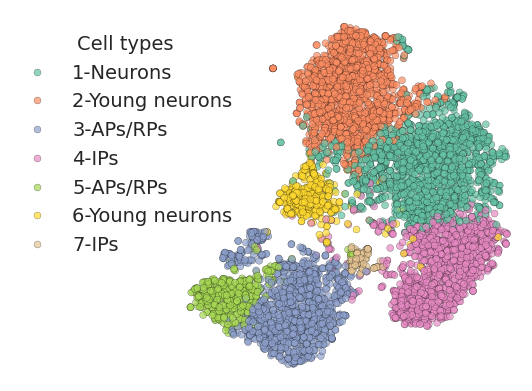

In [3]:
sns.set_context("paper")          # 글꼴·선 두께 자동 축소
sns.set_style("white")    

n_colors = adata.obs['cell_type2'].nunique()
cb_palette = sns.color_palette("Set2", n_colors)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

g1 = sns.scatterplot(data=adata.obs, x='tSNE_1', y='tSNE_2', hue='cell_type2', 
                     palette=cb_palette, s=25, linewidth=0.2,edgecolor='k', ax=axs, alpha=0.7,rasterized=True)

axs.axis("off")               # 축·눈금 제거
axs.legend(title="Cell types", prop={'size':14}, bbox_to_anchor=(-0.5, 0.98),title_fontsize=14,
               loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

### Run GTra

##### Upload time-series scRNA-seq data

In [4]:
obj = GTraObject()
obj.params.cell_type_label = "cell_type2"
obj.params.output_dir = "./Case2_MND"
obj.params.output_name = "Mouse"

# Upload time-series scRNA_seq data
for time in sorted(adata.obs["timepoints"].unique()):
    dat = adata[adata.obs["timepoints"]==time]
    cnt_dat = dat.to_df(layer="counts")
    meta = dat.obs[[obj.params.cell_type_label]]
    obj.upload_time_scRNA(cnt_dat, meta)

obj.select_genes()

##### Step 1: Identifying cell type-specific gene clusters

In [6]:
obj.find_gclusters(N=100)

Step 1: Identifying cell type-specific gene clusters...


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

##### GTra's ranked edges

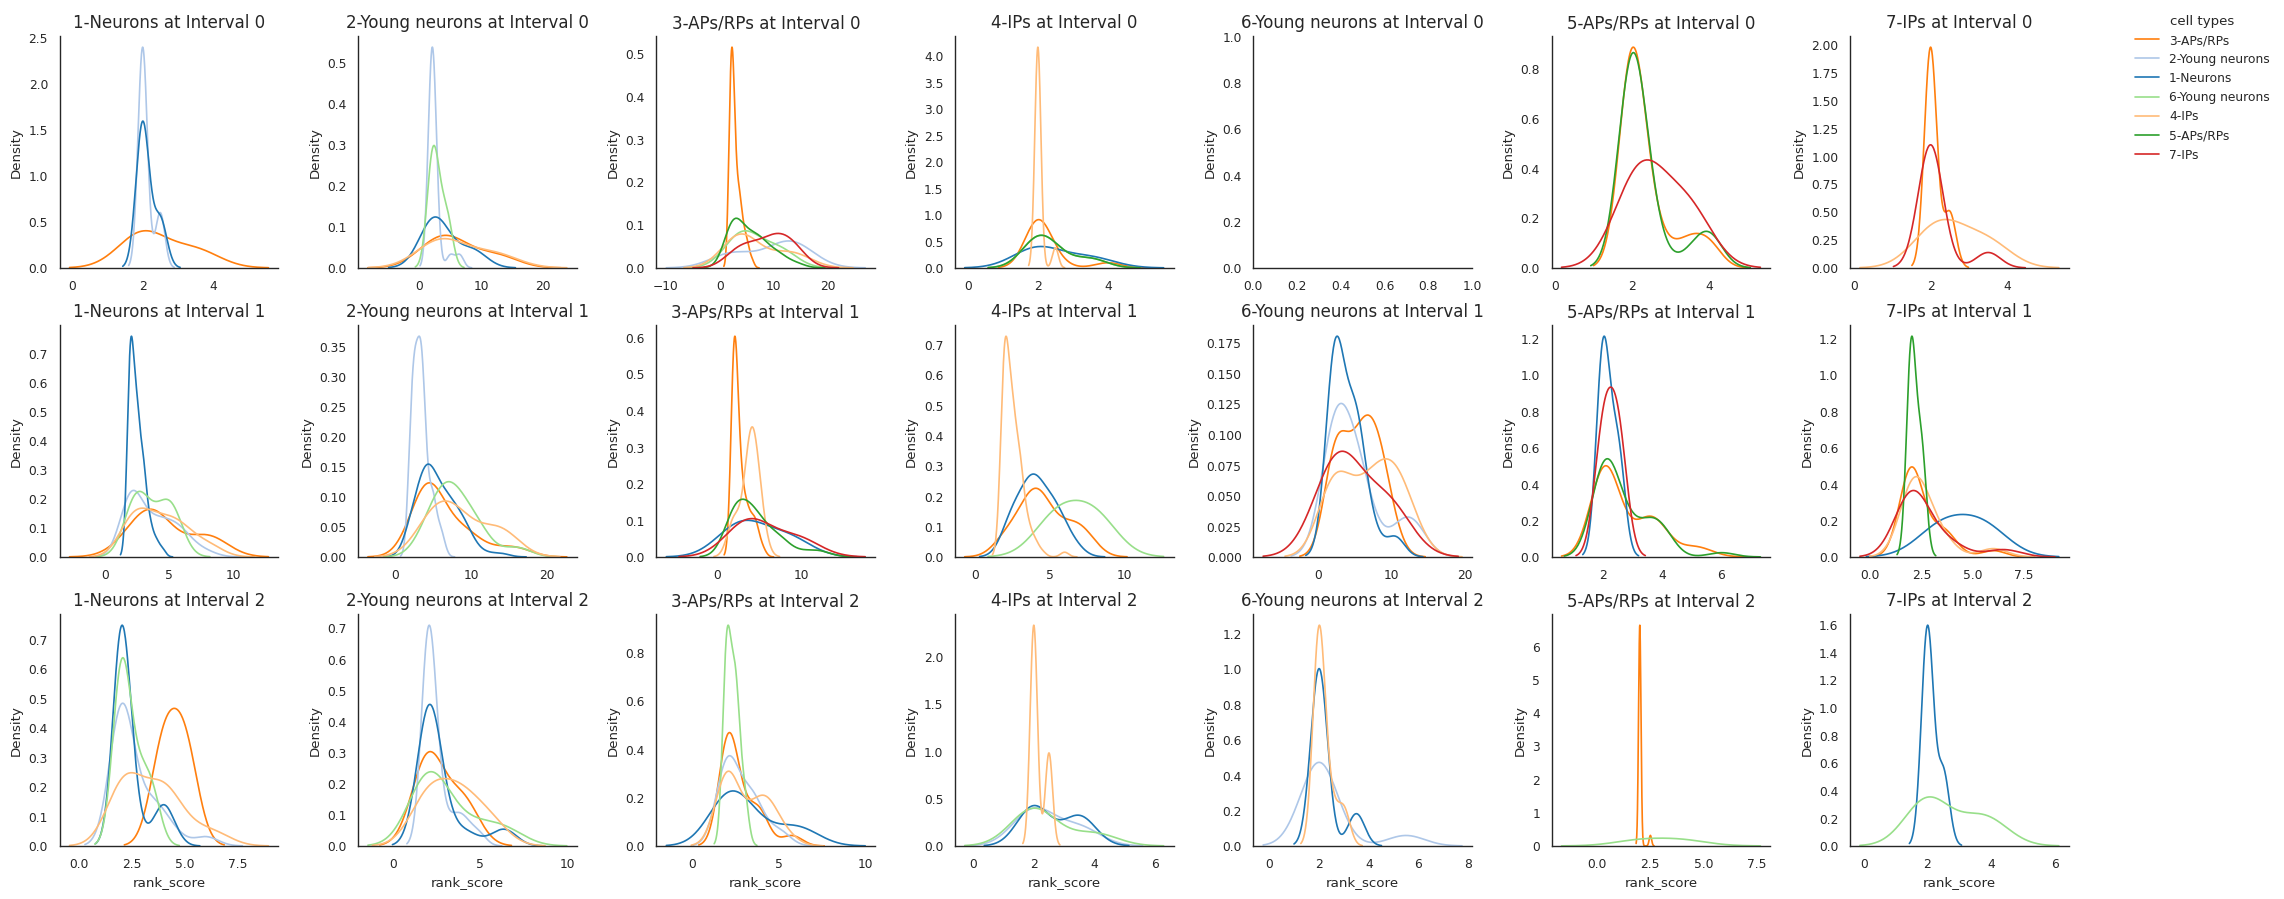

In [45]:
obj.plot_edge_stat()

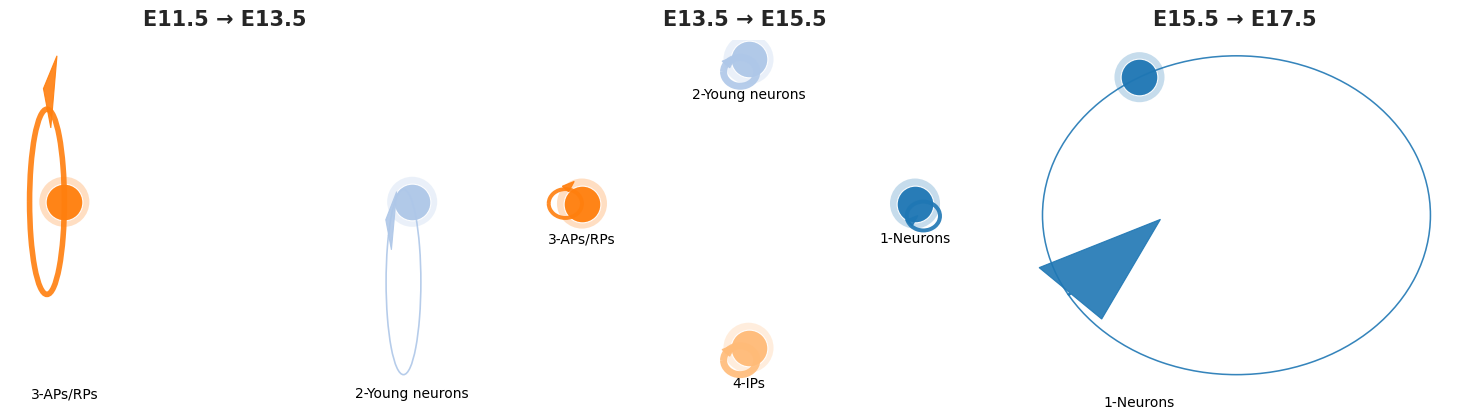

In [46]:
obj.params.time_point_label = ["E11.5","E13.5","E15.5","E17.5"]
obj.plot_transition_graph()

In [8]:
path_pvals = obj.pval_df.copy()
sig_paths = path_pvals[(path_pvals["Interval"]==0)]
sig_paths = sig_paths[(sig_paths["adj_p-value"]<=obj.pval_th)]

In [9]:
sig_paths

,Interval,source,target,p-value,adj_p-value
16,0,3-APs/RPs,3-APs/RPs,0.000001,0.000008


#### Step 2: Constructing cell-state trajectories

In [10]:
obj.construct_trajectory()

Construct cell-state trajectories...: 100%|===========================| 3/3 [00:19<00:00,  6.54s/it]


#### Stpe 3: Detecting cell trajectory-specific gene expression patterns

In [11]:
obj.pattern_clustering()

Step 3: Pattern clustering...: 100%|==================================| 4/4 [00:01<00:00,  2.02it/s]


Plotting time-series gene expression patterns...


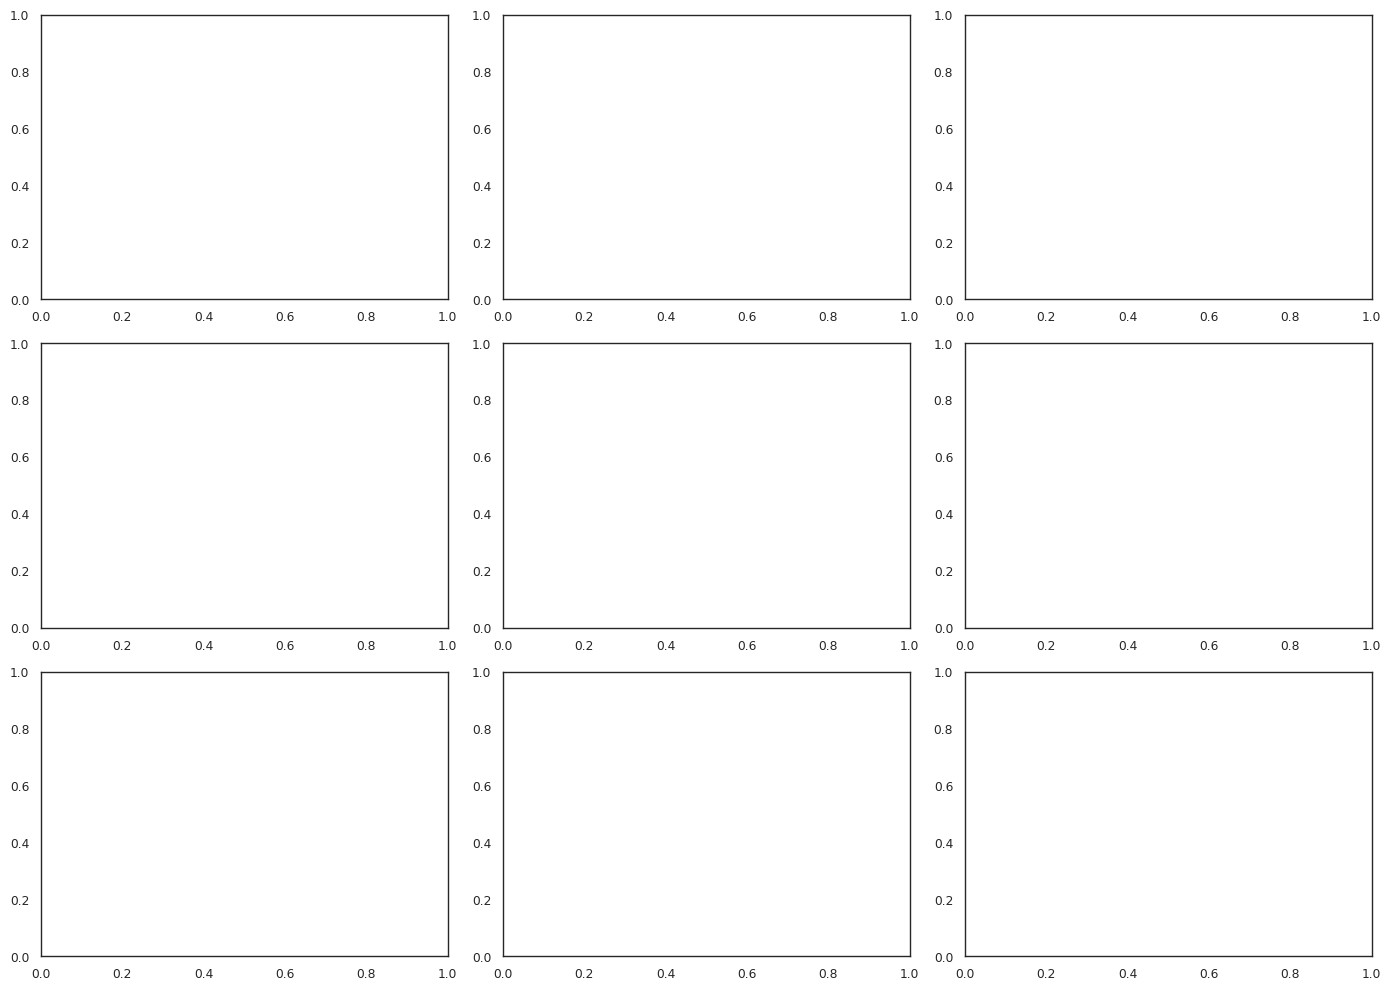

In [12]:
obj.plot_expressions()

In [13]:
with open("mouse_gtra.dill","rb") as f:
    gobj = dill.load(f)

In [15]:
gobj.tp_data_dict[0]

AnnData object with n_obs × n_vars = 1402 × 1034
    obs: 'cell_type2', 'cluster_label'

In [31]:
len(gobj.gene_label_info[0][5])

3

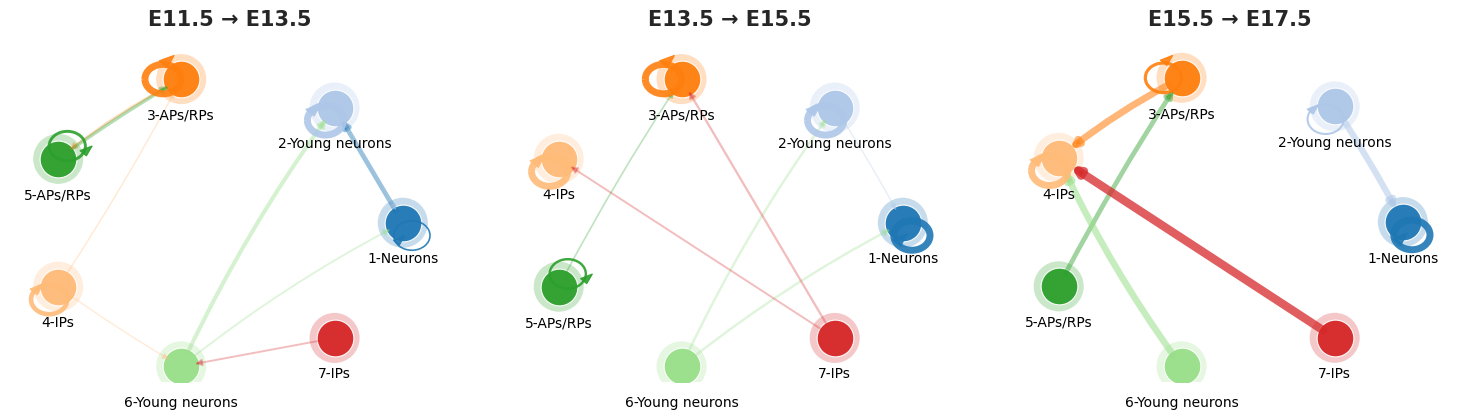

In [39]:
gobj.plot_transition_graph()

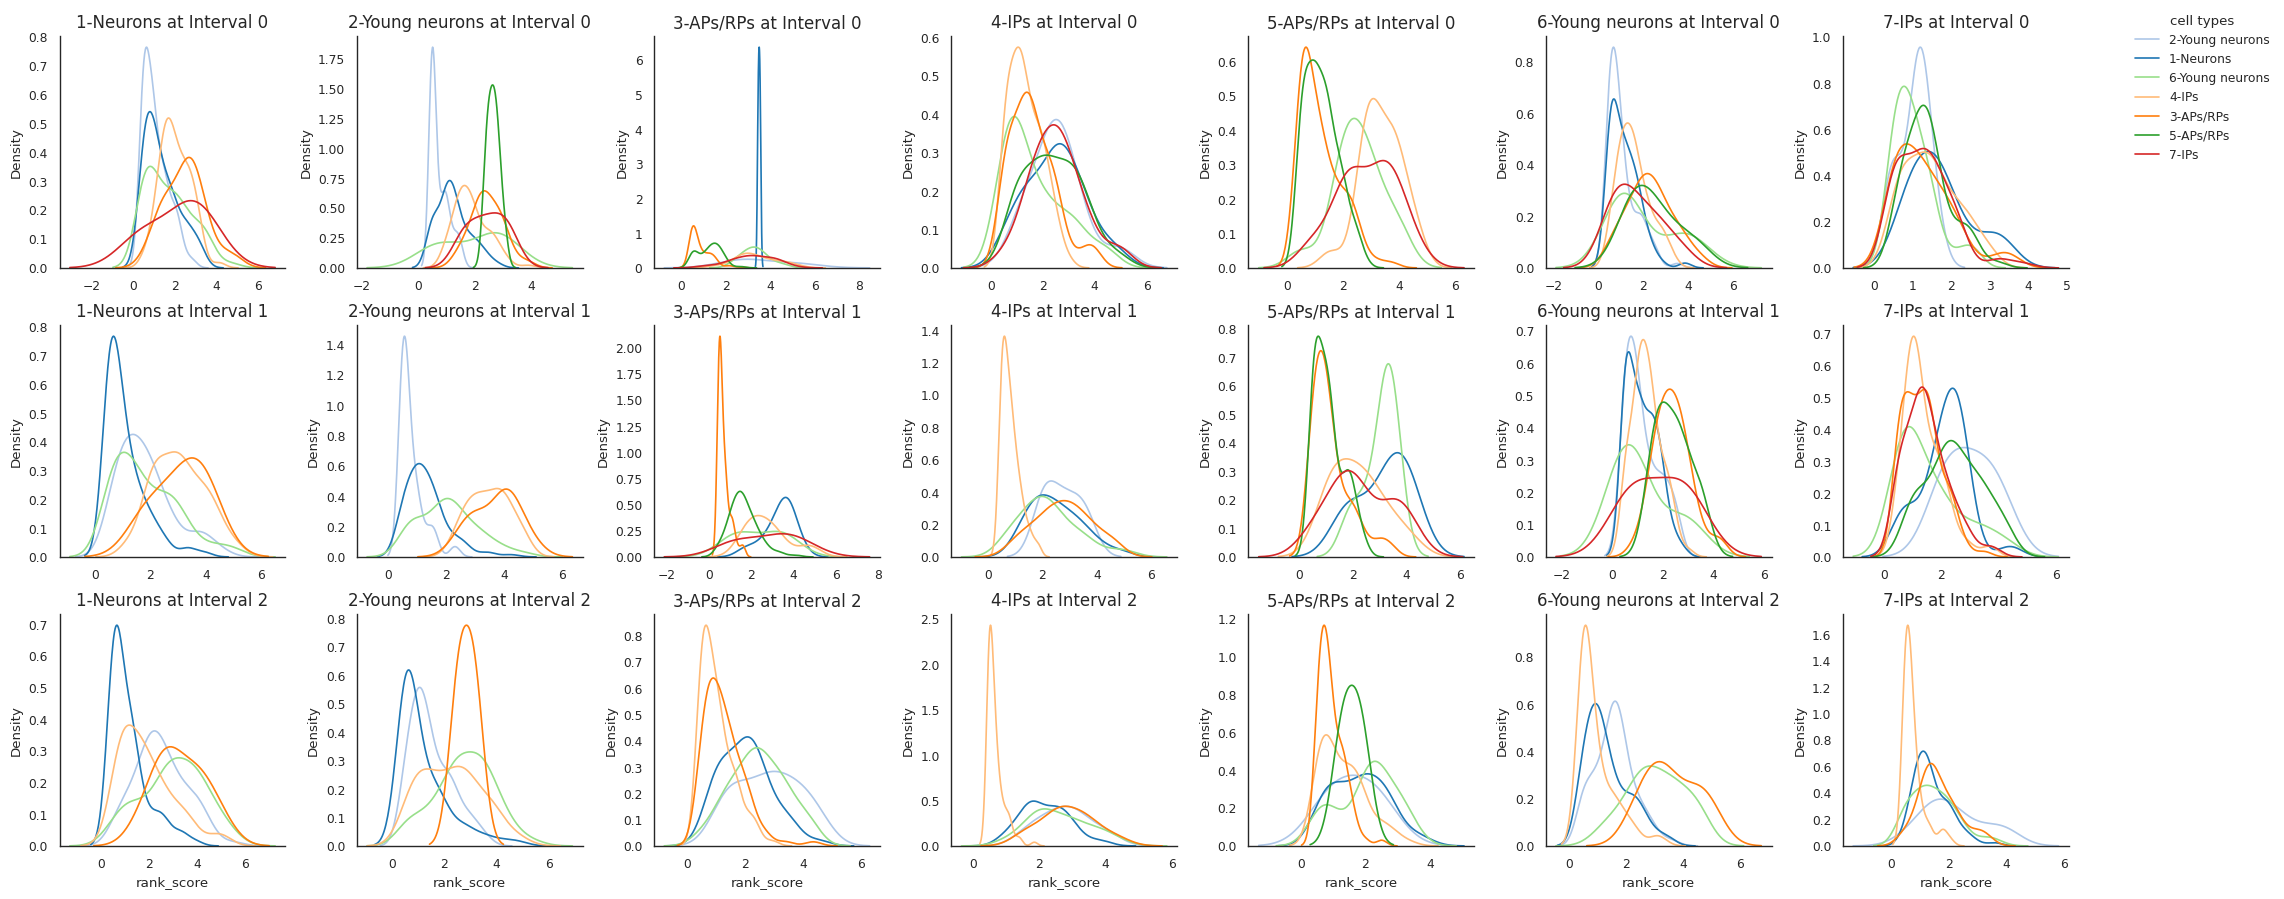

In [37]:
gobj.plot_edge_stat()

In [34]:
gobj.select_candidate_edges()

Construct cell-state trajectories...:   0%|                                   | 0/3 [00:06<?, ?it/s]


AttributeError: kw